# Sparkify (Music Streaming Service)
### by Nima Sayyah


<div>
<img src="Sparkify.jpeg" width="600"/>
</div>



## Table of Contents
* [Introduction](#int)
* [Data Wrangling](#load)
* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#eng)
* [Modelling](#model)
* [Conclusions](#con)

### Introduction
<a class="anchor" id="int"></a>

This project will take advantage of a music app dataset similar to Spotify platform. It will use Spark to extract relevant features for predicting churn. Churn signifies the service termination. Spotting customers before they churn, the business can offer discounts and incentives for their retention to stabilise the business revenue. This workspace contains a subset (128MB) of the full dataset available (12GB).

In [5]:
# Importing necessary libraries
import pyspark 
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Craeting a Spark session
spark = SparkSession.builder.appName("Sparkify Project").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/23 23:34:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.startTime', '1658615658537'),
 ('spark.executor.id', 'driver'),
 ('spark.app.submitTime', '1658615658103'),
 ('spark.driver.port', '51792'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.extraJavaOptions',
  '-XX:+I

### Data Wrangling
<a class="anchor" id="load"></a>
At this stage the data`mini_sparkify_event_data.json` is loaded processed and cleaned. 

In [8]:
# loading the dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [9]:
# Printing the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Computing basic statistics or information
df.summary()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [11]:
# Taking the first two element of the RDD Dataset
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [12]:
# The count of the dataset before cleaning 
df.count()

286500

### Drop Rows with Missing Values

It is reasonble to first explore missing values for ID related cells.

In [13]:
# Dropping rows with missing values in userid and/or sessionid
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [14]:
# Recounting the dataset
df.count()

286500

It appears there are no missing values. We however need further analysis. 

In [15]:
# Removing userId duplicates
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



As it can be seen there are empty strings used as **userId**. We proceed by removing those empty strings.

In [16]:
# Removing empty string userIds
df = df.filter(df["userId"] != "")

In [17]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [18]:
# Removing sessionId duplicates
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [19]:
# Recounting the dataset
df.count()

278154

This means we have dropped **286500** - **278154** = **8346** at this stage

In [20]:
# Exploring the dataset by Panda Dataframe 
df_pandas = df.toPandas()
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


## Exploratory Data Analysis
<a class="anchor" id="eda"></a>

At this section we will explore the actions taken by the users who churned versus those who stayed with the service. For that pupose, we have certain columnar information, such as the `length` and the `song`, to take the analysis forward.


### Churn Column

As explained in the introduction, **Churn** is defined as the service termination. Therfore, a column `Churn` will be created. `page` column is used to extract those labelled as `Cancellation Confirmation` and assign to those who churned. This is applied for both free and paid users. We will assign a **0** where a user has not churned and a **1** where they have churned.


In [21]:
# Exploring the page column classifications
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



As explained earlier, `Cancelalation Confirmation` identifies the users who confirmed termination from the service.

In [22]:
# Exploring those who churned 
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



In [23]:
# Identifying how many users churned 
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

Therefore, **52** users churned. 

We can now proceed to creating a flag for identifying churned and unchurned users. For this we assign the churned users to **1** and otherwise **0**.

In [24]:
# Using User Defined Function to flag the users in a new column
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("Churn", churn_event("page"))
df.select(["userId", "Churn"]).show()

+------+-----+
|userId|Churn|
+------+-----+
|    30|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|    30|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|    74|    0|
|    30|    0|
|     9|    0|
+------+-----+
only showing top 20 rows



In [25]:
df.select(["userId", "Churn"]).where(df.Churn == 1 ).show()

+------+-----+
|userId|Churn|
+------+-----+
|    18|    1|
|    32|    1|
|   125|    1|
|   105|    1|
|    17|    1|
|   143|    1|
|   101|    1|
|   129|    1|
|   121|    1|
|    51|    1|
|    87|    1|
|   122|    1|
|    12|    1|
|    58|    1|
|    73|    1|
|     3|    1|
|   106|    1|
|   103|    1|
|    28|    1|
|    54|    1|
+------+-----+
only showing top 20 rows



As it can be seen in the last cell, the `Churn` column has been created with the assigned values of **1** and **0**.

In [26]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
windowval

In [27]:
df = df.withColumn("churn", Fsum("churn").over(windowval))
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|                null|Logged In|  Bryanna|     F|           43|   Stone|     null| free|Los Angeles-Long ...|   PUT|     Logout|1537440271000|      201|                null|   307|1543335219000|Mozilla/5.0 (Maci...|100008|    0|
|Bembeya Jazz Nati...|Logged In|  Bryanna|     F|           42|   Stone|245.99465| f

In [28]:
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



### EDA for Users that Stayed vs Users that Churned

Now we can examine behaviour of those who churned vs those who did not churn. First we will visualise those who churned vs those who stayed.

In [29]:
# convert dataframe to pandas for visualisation
df_churn = df_churn.toPandas()
df_churn

,churn,count
0,0,173
1,1,52


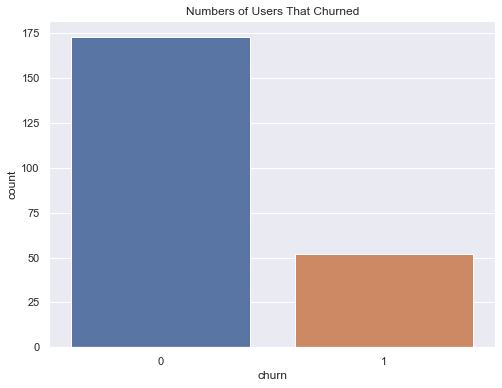

In [30]:
# plotting the number of churned users
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')
plt.title("Numbers of Users That Churned");

In [31]:
# churned rate calculation
52/(173+52) * 100

23.11111111111111

From the above, we can see that **173** users stayed while **52** users churned. Therefore this means that **23%** of our users churned. It is important to note moving forward that this is an imbalance.

### Length of time: Users that Churned vs. Users that Stayed

We can now look at the length distribution for customers who stayed and those which churned. 

In [32]:
# the customers who churned (sample)
df_len = df.filter(df.churn ==1)
df_len.show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|  null|Cancelled|  Rodrigo|     M|           73|   Carey|  null| paid|New York-Newark-J...|   GET|Cancellation Conf...|1535389443000|      185|null|   200|1542740649000|"Mozilla/5.0 (Win...|100014|    1|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+----------

In [33]:
# convert to pandas
df_pd = df_len.toPandas()
df_pd

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,None,Cancelled,Rodrigo,M,73,Carey,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Cancellation Confirmation,1535389443000,185,None,200,1542740649000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100014,1
1,None,Logged In,Rodrigo,M,72,Carey,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Cancel,1535389443000,185,None,307,1542740642000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100014,1
2,None,Logged In,Rodrigo,M,71,Carey,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Downgrade,1535389443000,185,None,200,1542740641000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100014,1
3,CREMATORY,Logged In,Rodrigo,M,70,Carey,247.48363,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1535389443000,185,Hoffnungen,200,1542740628000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100014,1
4,Kaskade,Logged In,Rodrigo,M,69,Carey,276.03546,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1535389443000,185,Sorry,200,1542740352000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44859,Pompeii,Logged In,Liliana,F,4,Owen,301.60934,free,"Detroit-Warren-Dearborn, MI",PUT,NextSong,1535032914000,21,Until You're Floating,200,1538586748000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,200021,1
44860,None,Logged In,Liliana,F,3,Owen,NaN,free,"Detroit-Warren-Dearborn, MI",PUT,Thumbs Down,1535032914000,21,None,307,1538586473000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,200021,1
44861,Blackalicious,Logged In,Liliana,F,2,Owen,276.84526,free,"Detroit-Warren-Dearborn, MI",PUT,NextSong,1535032914000,21,Side To Side (Featuring Lateef & Pigeon John) ...,200,1538586472000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,200021,1
44862,R.I.O.,Logged In,Liliana,F,1,Owen,217.12934,free,"Detroit-Warren-Dearborn, MI",PUT,NextSong,1535032914000,21,When The Sun Comes Down,200,1538586255000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,200021,1


In [34]:
# drop the nulls
df_pd.length.dropna(inplace=True)

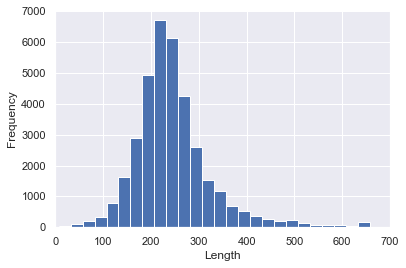

In [35]:
# plot the distribution
bin_edges = np.arange (7, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

In [36]:
# the customers who didn't churn (sample)
df_len_stay = df.filter(df.churn ==0)
df_len_stay.show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-----+
|  null|Logged In|  Bryanna|     F|           43|   Stone|  null| free|Los Angeles-Long ...|   PUT|Logout|1537440271000|      201|null|   307|1543335219000|Mozilla/5.0 (Maci...|100008|    0|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-----+
only showing top 1 row



In [37]:
# convert to pandas
df_pd = df_len_stay.toPandas()
df_pd

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,None,Logged In,Bryanna,F,43,Stone,NaN,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,Logout,1537440271000,201,None,307,1543335219000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,100008,0
1,Bembeya Jazz National,Logged In,Bryanna,F,42,Stone,245.99465,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1537440271000,201,Alalake,200,1543335218000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,100008,0
2,Ralph Stanley,Logged In,Bryanna,F,41,Stone,199.57506,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1537440271000,201,O Death,200,1543335019000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,100008,0
3,Brotha Lynch Hung,Logged In,Bryanna,F,40,Stone,67.91791,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1537440271000,201,Q-Ball,200,1543334952000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,100008,0
4,Everclear,Logged In,Bryanna,F,39,Stone,257.14893,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1537440271000,201,Why I Don't Believe In God,200,1543334695000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,100008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233285,Kaizers Orchestra,Logged In,Ellen,F,5,Romero,224.99220,free,"Omaha-Council Bluffs, NE-IA",PUT,NextSong,1531350022000,192,Christiania,200,1538413499000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",94,0
233286,Arcade Fire,Logged In,Ellen,F,4,Romero,234.05669,free,"Omaha-Council Bluffs, NE-IA",PUT,NextSong,1531350022000,192,Brazil,200,1538413265000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",94,0
233287,None,Logged In,Ellen,F,3,Romero,NaN,free,"Omaha-Council Bluffs, NE-IA",GET,Roll Advert,1531350022000,192,None,200,1538413054000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",94,0
233288,Alliance Ethnik,Logged In,Ellen,F,2,Romero,252.21179,free,"Omaha-Council Bluffs, NE-IA",PUT,NextSong,1531350022000,192,ReprÃÂ©sente,200,1538413013000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",94,0


In [38]:
# drop the nulls
df_pd.length.dropna(inplace=True)

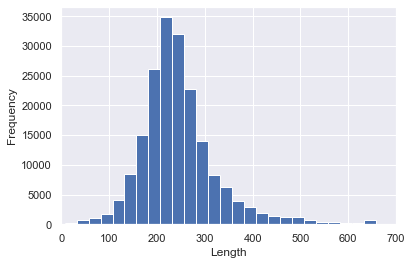

In [39]:
# plot distribution
bin_edges = np.arange (7, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

The above plots demonstarets that length distribution is very similar for users that churned and those who stayed. This is not te best variable to predict those customers who churned . We can now analyse gender as a categorical feature.

###  Users who Churned vs Users who Stayed by Gender

We can now examine if gender had an effect on users that churned vs. those that stayed.

In [40]:
# create gender df grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [41]:
# convert to pandas for visualisation
df_gender = df_gender.toPandas()
df_gender

,gender,churn,count
0,F,0,84
1,F,1,20
2,M,0,89
3,M,1,32


In [42]:
# order for the visualisation
df_gender = df_gender.sort_values('count', ascending = False)
df_gender

,gender,churn,count
2,M,0,89
0,F,0,84
3,M,1,32
1,F,1,20


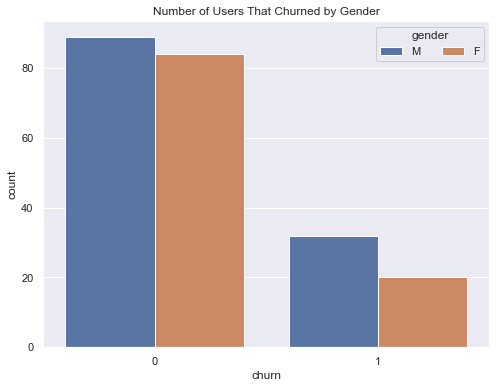

In [43]:
# seaborn barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users That Churned by Gender");

In [44]:
# male churn rate
32/(89+32)

0.2644628099173554

In [45]:
# female churn rate
20/(20+84)

0.19230769230769232

From the above chart, we can see that more male users churned(rate of 0.264) compared to female users (rate of 0.192).

### Users who Churned vs Stayed by Level

Next we can examine if level has an effect on whether a user will churn or not. By level here we mean if the user paid for the app or if they used it for free with ads.

In [46]:
# create the level dataframe
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [47]:
# convert to pandas for visualisation
df_level = df_level.toPandas()
df_level

,level,churn,count
0,free,0,149
1,paid,0,129
2,free,1,46
3,paid,1,36


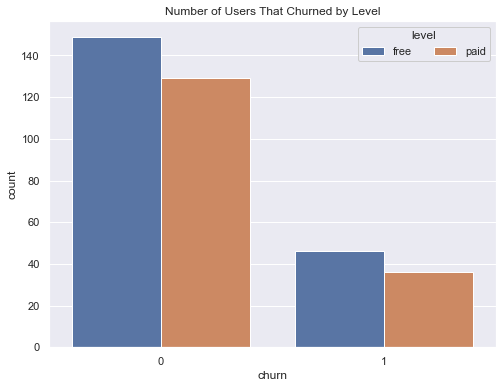

In [48]:
# plot the barplot using seaborn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of Users That Churned by Level");

In [49]:
# free churn rate
46/(46+149)

0.2358974358974359

In [50]:
# paid churn rate
36/(129+36)

0.21818181818181817

More users who used the service for free were slightly more likely to churn, rate of **0.236**,compared to those who paid for the app, rate of **0.218**.

### Pages Visited by Those that Churned vs. Those That Stayed

In [51]:
# create the page dataframe
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()
df_page.show()

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0| 1244|
|         Thumbs Down|    1|  496|
|           Thumbs Up|    1| 1859|
|     Add to Playlist|    1| 1038|
|               Error|    1|   32|
|               About|    1|   56|
|         Thumbs Down|    0| 2050|
|         Roll Advert|    1|  967|
|                Home|    0| 8410|
|Cancellation Conf...|    1|   52|
|               Error|    0|  220|
|              Cancel|    1|   52|
|            Settings|    1|  270|
|          Add Friend|    1|  636|
|             Upgrade|    0|  387|
|           Downgrade|    1|  337|
|              Logout|    1|  553|
|    Submit Downgrade|    1|    9|
|       Save Settings|    0|  252|
|           Thumbs Up|    0|10692|
+--------------------+-----+-----+
only showing top 20 rows



In [52]:
# convert to pandas
df_page = df_page.toPandas()
df_page

,page,churn,count
0,Settings,0,1244
1,Thumbs Down,1,496
2,Thumbs Up,1,1859
3,Add to Playlist,1,1038
4,Error,1,32
5,About,1,56
6,Thumbs Down,0,2050
7,Roll Advert,1,967
8,Home,0,8410
9,Cancellation Confirmation,1,52


In [53]:
# Select pages for those who churned
df_page[df_page['churn'] == 1]

,page,churn,count
1,Thumbs Down,1,496
2,Thumbs Up,1,1859
3,Add to Playlist,1,1038
4,Error,1,32
5,About,1,56
7,Roll Advert,1,967
9,Cancellation Confirmation,1,52
11,Cancel,1,52
12,Settings,1,270
13,Add Friend,1,636


In [54]:
# create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
churn_count

page     Thumbs DownThumbs UpAdd to PlaylistErrorAboutR...
churn                                                   19
count                                                44864
dtype: object

In [55]:
# Select pages for those who didn't churn
df_page[df_page['churn'] == 0]

,page,churn,count
0,Settings,0,1244
6,Thumbs Down,0,2050
8,Home,0,8410
10,Error,0,220
14,Upgrade,0,387
18,Save Settings,0,252
19,Thumbs Up,0,10692
20,Downgrade,0,1718
21,Submit Upgrade,0,127
22,Roll Advert,0,2966


In [56]:
# create counts for those who churned and those who didn't stay
stay_count =  df_page[df_page['churn'] == 0].sum()
stay_count

page     SettingsThumbs DownHomeErrorUpgradeSave Settin...
churn                                                    0
count                                               233290
dtype: object

Now that we have a count of the number of customers who churned and those that stayed we can calculate the rate and create this as a column on our dataFrame.

In [57]:
# calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count']))

In [58]:
df_page.head(20)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


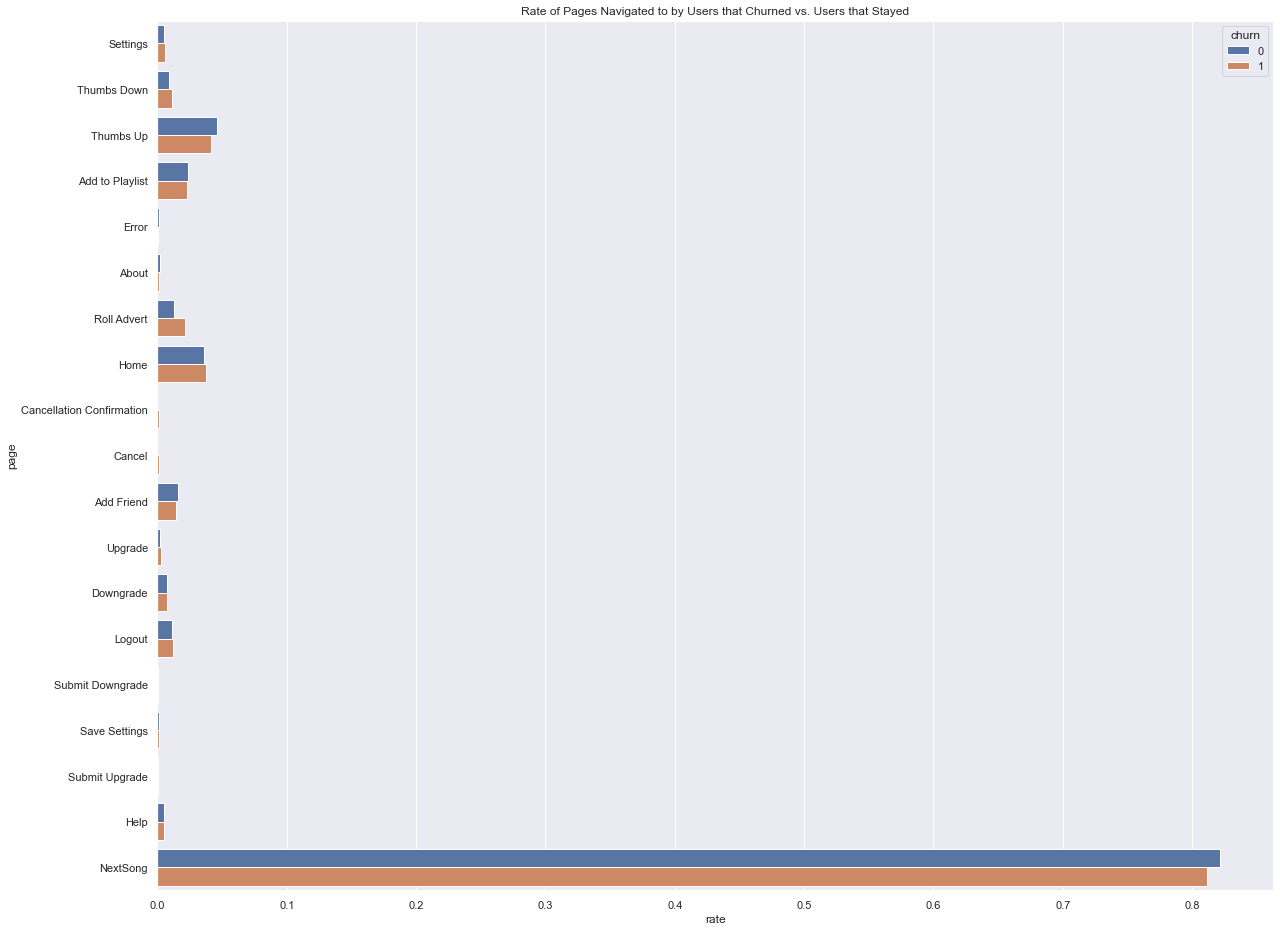

In [59]:
# plot the pages by churn
plt.figure(figsize=[20,16])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed');

The above chart indicates that the most popular action for both users that stayed and those that churned was to skip to the next song. Also churned users rolled the ad and thumbs down songs more than those who were more likely to stayed whome performed more thumbs up actions, added friends and also added songs to playlist.

### Calculating Songs per Hour

Here is the calculation for the number of songs listened to by churn and non churn users per hour. 

In [60]:
# get hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [61]:
# create hour column
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist=None, auth='Logged In', firstName='Bryanna', gender='F', itemInSession=43, lastName='Stone', length=None, level='free', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='Logout', registration=1537440271000, sessionId=201, song=None, status=307, ts=1543335219000, userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', userId='100008', churn=0, hour='16')

In [62]:
# create a df with those who didnt churn and which counts when user goes to next song page
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))
songs_in_hour_stay.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 7763|
|   1| 7337|
|   2| 7000|
|   3| 7009|
|   4| 6934|
|   5| 6779|
|   6| 6906|
|   7| 6905|
|   8| 7003|
|   9| 7098|
|  10| 7308|
|  11| 7300|
|  12| 7877|
|  13| 8043|
|  14| 8508|
|  15| 9223|
|  16| 9529|
|  17| 9682|
|  18| 9327|
|  19| 8984|
|  20| 9106|
|  21| 9135|
|  22| 8655|
|  23| 8303|
+----+-----+



In [63]:
# convert to pandas and then to numeric
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)
songs_in_hour_stay_pd

,hour,count
0,0,7763
1,1,7337
2,2,7000
3,3,7009
4,4,6934
5,5,6779
6,6,6906
7,7,6905
8,8,7003
9,9,7098


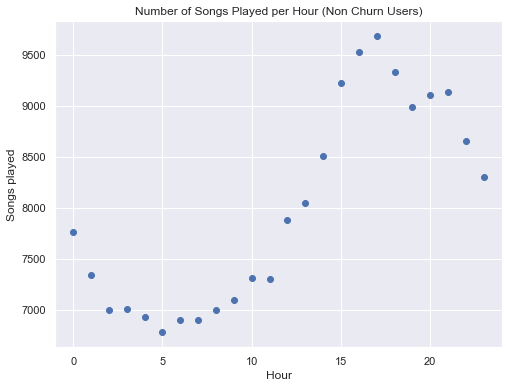

In [64]:
#plot the distribution
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour (Non Churn Users)");

We can see that there is a peak of songs played between 3pm and 8pm. Next we will examine users who churned by using the same process.

In [69]:
# dataframe with customers who churned and count next song page 
songs_in_hour_churned = df.filter((df.page == "NextSong") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))
songs_in_hour_churned.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1564|
|   1| 1558|
|   2| 1339|
|   3| 1350|
|   4| 1295|
|   5| 1200|
|   6| 1208|
|   7| 1214|
|   8| 1222|
|   9| 1261|
|  10| 1294|
|  11| 1353|
|  12| 1348|
|  13| 1436|
|  14| 1539|
|  15| 1813|
|  16| 1852|
|  17| 1886|
|  18| 2019|
|  19| 1956|
+----+-----+
only showing top 20 rows



In [70]:
# convert to pandas and to numeric
songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned.hour = pd.to_numeric(songs_in_hour_churned.hour)
songs_in_hour_churned

,hour,count
0,0,1564
1,1,1558
2,2,1339
3,3,1350
4,4,1295
5,5,1200
6,6,1208
7,7,1214
8,8,1222
9,9,1261


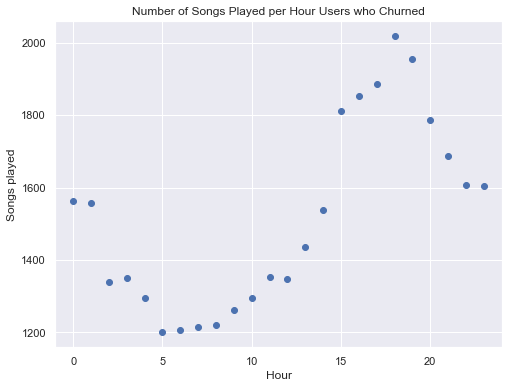

In [71]:
#plot distribution of songs per hour for churned
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_churned["hour"], songs_in_hour_churned["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned");

We conclude users who churned had a similar distribution, however, they listened to fewer songs per hour than users that stayed.

### Songs Per Session for Users who Churned vs. Those who Stayed

We can plot this in a simple way which will allow us to compare those who churned and those who stayed in a bar chart by getting the averages for both groups.

In [79]:
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

In [80]:
# get average grouped by churn
df_songs.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [81]:
df_songs = df_songs.groupby('churn').agg({"count":"avg"})
df_songs

DataFrame[churn: bigint, avg(count): double]

In [82]:
# convert this to pandas df
df_songs = df_songs.toPandas()
df_songs

,churn,avg(count)
0,0,93.336904
1,1,79.811404


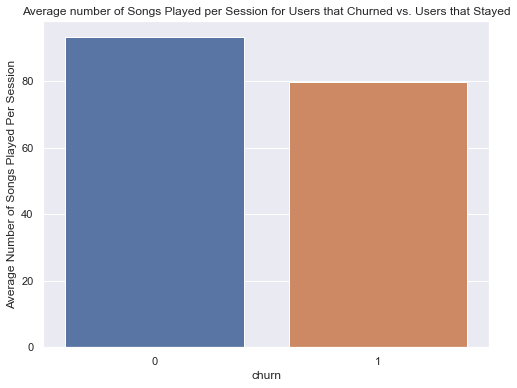

In [83]:
#plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_songs, x = 'churn', y='avg(count)')
plt.title("Average number of Songs Played per Session for Users that Churned vs. Users that Stayed")
plt.ylabel("Average Number of Songs Played Per Session");

Unsurprisingly those churned from Sparkify actually listening to fewer songs on average per session.

### Number of Unique Artists Listened to

We can create a similar chart for the number of artists that users listened to.

In [84]:
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()
df_artists

DataFrame[userId: string, churn: bigint, count: bigint]

In [85]:
# get averages
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [86]:
# convert to pandas
df_artists = df_artists.toPandas()
df_artists

,userId,churn,count
0,100008,0,624
1,100010,0,253
2,100014,1,234
3,100021,1,208
4,100022,1,556
...,...,...,...
220,80,0,327
221,83,0,927
222,88,0,1359
223,91,0,1619


Text(0.5, 1.0, 'Number of Artists Listened to on Sparkify')

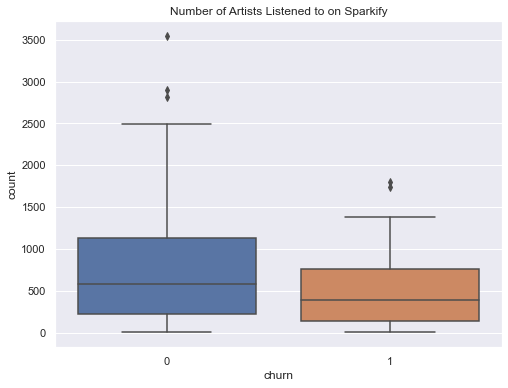

22/07/25 12:43:26 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1723302 ms exceeds timeout 120000 ms
22/07/25 12:43:26 WARN SparkContext: Killing executors is not supported by current scheduler.


In [87]:
#plot boxplot
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = df_artists, x = 'churn', y='count')
plt.title("Number of Artists Listened to on Sparkify")

The boxplot demonstrates the max and medians for both groups. It shows that those who didn't churn listened to a larger number of different artists compared to those who churned.

### Location on Churn vs Staye

In [88]:
df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
|Allentown-Bethleh...|  815|
|Miami-Fort Lauder...| 3764|
|           Selma, AL| 2027|
+--------------------+-----+
only showing top 20 rows



Let's just extract the state from the location by taking the last two characters in the location string.

In [97]:
# get last two characters
get_state = udf(lambda x: x[-2:])

In [105]:
# create state column
df_state = df.withColumn("state", get_state(df.location))

In [91]:
# check that create state column worked
df_state.take(2)

[Row(artist=None, auth='Logged In', firstName='Bryanna', gender='F', itemInSession=43, lastName='Stone', length=None, level='free', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='Logout', registration=1537440271000, sessionId=201, song=None, status=307, ts=1543335219000, userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', userId='100008', churn=0, hour='16', state='CA'),
 Row(artist='Bembeya Jazz National', auth='Logged In', firstName='Bryanna', gender='F', itemInSession=42, lastName='Stone', length=245.99465, level='free', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='NextSong', registration=1537440271000, sessionId=201, song='Alalake', status=200, ts=1543335218000, userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', userId='100008', churn=0, hour='16', state='CA')]

In [106]:
df_state = df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()

In [107]:
# convert to pandas 
df_state_pd = df_state.toPandas()
df_state_pd

,state,churn,count
0,AL,0,4
1,IL,0,8
2,AZ,1,2
3,OH,0,1
4,AL,1,2
...,...,...,...
57,NY,0,4
58,TN,0,1
59,FL,0,11
60,NY,1,1


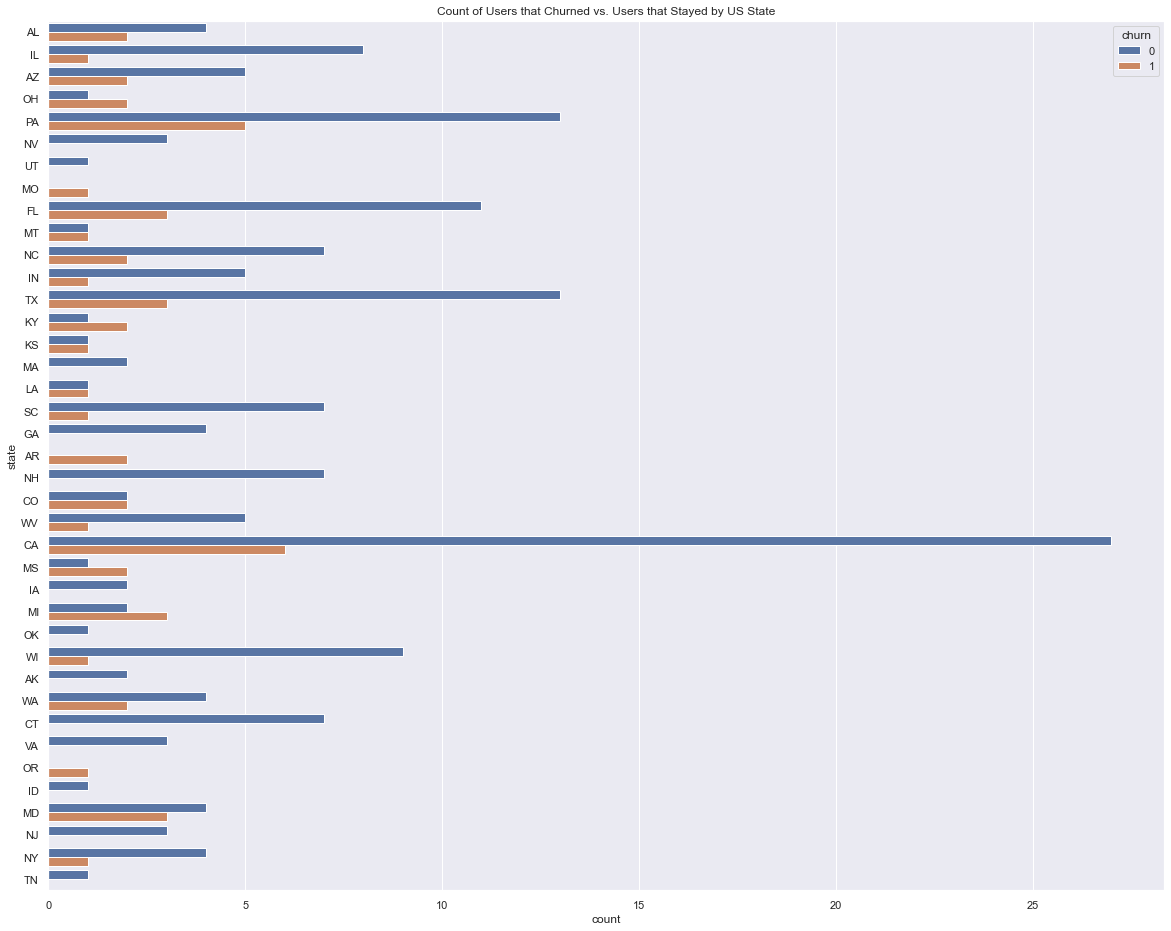

In [94]:
# plot 
plt.figure(figsize=[20,16])
sns.barplot(data = df_state_pd, x = 'count', y = 'state', hue = 'churn')
plt.title('Count of Users that Churned vs. Users that Stayed by US State');

Most users were based in CA. More users in MI, KY, and OH states churned than stayed. This may be difficult to engineer a useful feature for when it comes to modelling. Let's leave this for now and move onto another column from our dataset; operating systems and browsers.

### UserAgent: Operating System and Browsers


Now we can extract the Operating System a user is on to understand if this has an effect on churn.

In [119]:
df_opsys = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])
df_opsys.show()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|   100|Mozilla/5.0 (Wind...|    0|
|100005|"Mozilla/5.0 (Mac...|    1|
|100006|"Mozilla/5.0 (Win...|    1|
|100007|"Mozilla/5.0 (Win...|    1|
|100008|Mozilla/5.0 (Maci...|    0|
|100009|"Mozilla/5.0 (Win...|    1|
|100010|"Mozilla/5.0 (iPh...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|100021|"Mozilla/5.0 (Mac...|    1|
|100022|Mozilla/5.0 (Maci...|    1|
|100025|"Mozilla/5.0 (Mac...|    1|
|   101|Mozilla/5.0 (Wind...|    1|
|   107|Mozilla/5.0 (Wind...|    0|
|    11|Mozilla/5.0 (Wind...|    0|
|   110|"Mozilla/5.0 (Mac...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
|   113|"Mozilla/5.0 (Mac...|    0|
|   118|"Mozilla/5.0 (Win...|    0|
|   120|"Mozilla/5.0 (Mac...|    0|
|   124|"Mozilla/5.0 (Mac...|    0|
+------+--------------------+-----+
only showing top 20 rows



In [120]:
# convert to pandas
df_opsys = df_opsys.toPandas()
df_opsys

,userId,userAgent,churn
0,100,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,0
1,100005,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1
2,100006,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1
3,100007,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1
4,100008,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,0
...,...,...,...
220,92,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",0
221,93,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,0
222,94,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",0
223,95,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,0


In [124]:
# get the possible list of operating systems
df_opsys.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       18
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     16
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        12
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                10
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"     

In [125]:
# create list of operating systems
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]

In [126]:
# create os column and extract strings that match our os_list and add to column 
df_opsys['os'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [127]:
# check that worked
df_opsys

,userId,userAgent,churn,os
0,100,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,0,Windows
1,100005,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
2,100006,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows
3,100007,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows
4,100008,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,0,Mac
...,...,...,...,...
220,92,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",0,iPad
221,93,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,0,Windows
222,94,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",0,Windows
223,95,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,0,Mac


In [128]:
df_opsys.os.value_counts()

Windows    111
Mac         86
iPhone      13
Linux       12
iPad         3
Name: os, dtype: int64

In [129]:
# order for the plot
os_order = df_opsys.os.value_counts().index

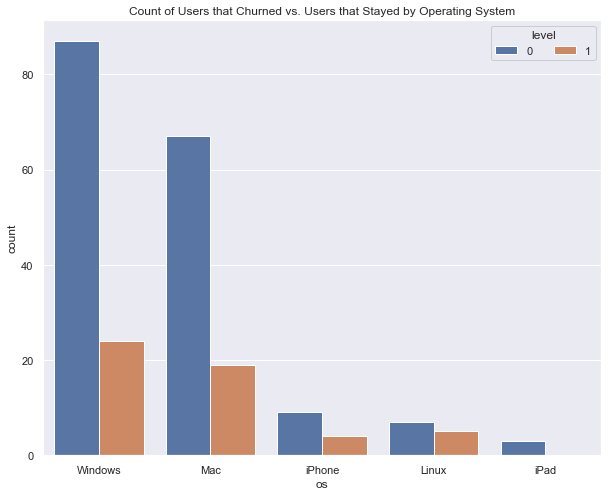

In [130]:
# plot count for churn and non churn users
plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'os', hue ='churn', order = os_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Operating System')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Windows was the most used. Linux users have the highest rate of churn. It is very few customers that this has affected therefore this won't be used in our model. Next, we can also look if browsers had an effect on churn using the same process.

In [131]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

In [132]:
df_opsys['browser'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

In [133]:
df_opsys.browser.value_counts()

Chrome     117
Firefox     50
Safari      46
Trident     12
Name: browser, dtype: int64

Here Trident is Internet Explorer software. Let's change Trident to 'Internet Explorer' as it is better known.

In [134]:
df_opsys['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)

In [136]:
# order for the plot
browser_order = df_opsys.browser.value_counts().index

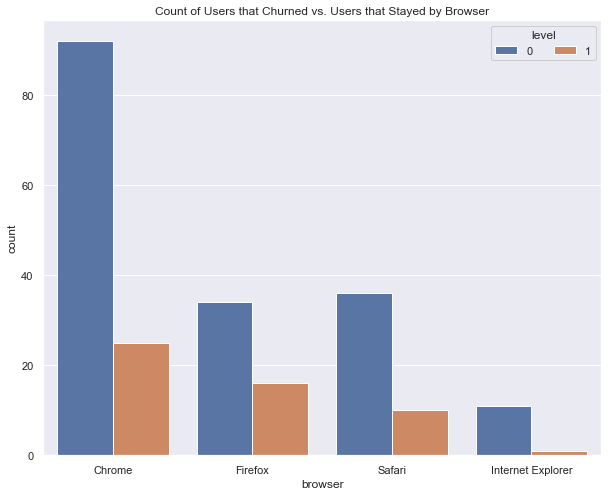

In [137]:
plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'browser', hue ='churn', order = browser_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Chrome was the most popular browser. Firefox users were most likely to churn. Internet Explorer had the fewest number of users that churned. There is no clear issue with browsers which is making users churn. Therefore this won't be used in our model.

### Days Since Registration for Sparkify

In [138]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [139]:
# order by last timestamp
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [148]:
# create a rank with the most recent timestamp as rank number 1
df_days = df_days.withColumn("Rank", dense_rank().over(w))
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|   100|1537982255000|1543587349000|    0|   1|
|100001|1534627466000|1538498205000|    1|   1|
|100002|1529934689000|1543799476000|    0|   1|
|100003|1537309344000|1539274781000|    1|   1|
|100004|1528560242000|1543459065000|    0|   1|
|100005|1532610926000|1539971825000|    1|   1|
|100006|1537964483000|1538753070000|    1|   1|
|100007|1533522419000|1543491909000|    1|   1|
|100008|1537440271000|1543335219000|    0|   1|
|100009|1537376437000|1540611104000|    1|   1|
|100010|1538016340000|1542823952000|    0|   1|
|100011|1537970819000|1538417085000|    1|   1|
|100012|1537381154000|1541100900000|    1|   1|
|100013|1537367773000|1541184816000|    1|   1|
|100014|1535389443000|1542740649000|    1|   1|
|100015|1537208989000|1543073753000|    1|   1|
|100016|1536854322000|1543335647000|    

In [149]:
# just get those with a rank of 1 i.e the first rows
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [150]:
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

In [151]:
# need to minus the registration from ts 
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [152]:
df_days.show()

+------+-------------+-------------+-----+-----------+
|userId| registration|           ts|churn| delta_days|
+------+-------------+-------------+-----+-----------+
|    10|1538159495000|1542631788000|    0| 4472293000|
|   100|1537982255000|1543587349000|    0| 5605094000|
|100001|1534627466000|1538498205000|    1| 3870739000|
|100002|1529934689000|1543799476000|    0|13864787000|
|100003|1537309344000|1539274781000|    1| 1965437000|
|100004|1528560242000|1543459065000|    0|14898823000|
|100005|1532610926000|1539971825000|    1| 7360899000|
|100006|1537964483000|1538753070000|    1|  788587000|
|100007|1533522419000|1543491909000|    1| 9969490000|
|100008|1537440271000|1543335219000|    0| 5894948000|
|100009|1537376437000|1540611104000|    1| 3234667000|
|100010|1538016340000|1542823952000|    0| 4807612000|
|100011|1537970819000|1538417085000|    1|  446266000|
|100012|1537381154000|1541100900000|    1| 3719746000|
|100013|1537367773000|1541184816000|    1| 3817043000|
|100014|15

In [153]:
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

In [154]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [156]:
# to Pandas for the plot
df_days_pd = df_days.toPandas()
df_days_pd

,userId,registration,ts,churn,delta_days,days
0,10,1538159495000,1542631788000,0,4472293000,51.762650
1,100,1537982255000,1543587349000,0,5605094000,64.873773
2,100001,1534627466000,1538498205000,1,3870739000,44.800220
3,100002,1529934689000,1543799476000,0,13864787000,160.472072
4,100003,1537309344000,1539274781000,1,1965437000,22.748113
...,...,...,...,...,...,...
220,95,1538211832000,1543591644000,0,5379812000,62.266343
221,96,1537149749000,1543537879000,0,6388130000,73.936690
222,97,1536019842000,1543570634000,0,7550792000,87.393426
223,98,1538069638000,1543548229000,0,5478591000,63.409618


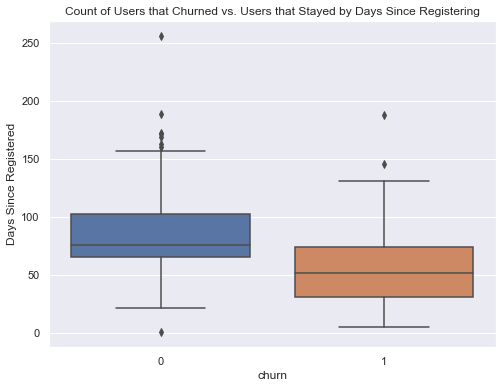

In [157]:
# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df_days_pd, x = 'churn', y ='days')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered");

On average those who had been registered with Sparkify for longer were more likely to stay. Users who had registered more recently were more likely to churn.

# Feature Engineering
<a class="anchor" id="eng"></a>

Now that EDA has been performed, we can build out the features that seem most promising to train our model on.

The features we will build out are:
- Categorical:
 - gender
 - level

- Numerical:
 - number of songs per session
 - number of rollads actions
 - number of thumb down actions
 - number of thumbs up actions
 - number of friends added
 - number of songs added to playlist
 - number of different artists listened to on Sparkify
 - number of days since registering
 
We will also then add a churn label and join these all together. This will create a dataFrame where each row represents information pertaining to each individual user. Once we drop the userId, this dataframe can be vectorised, standarised and fed into our different machine learning algorithms.

First we will take our categorical variables and convert these into numeric variables, ready for our model.

### Gender

Our first feature is gender which is a categorical one. We will assign a 1 for 'female' and a 0 for 'male'.

In [164]:
gender_f1 = df.select(['userId', 'gender']).dropDuplicates()

In [165]:
# create gender column 
gender_f1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))
gender_f1.count()

225

In [166]:
# check
gender_f1.show(20)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    39|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   100|     0|
|    25|     1|
|    92|     1|
|    52|     1|
|   110|     0|
|    33|     0|
|    42|     1|
|    67|     0|
|    77|     1|
|   136|     1|
|    99|     1|
|   114|     0|
+------+------+
only showing top 20 rows



### Level

The next feature we will take is level. The level can change so we need to only take the most recent. We can use the rank trick from before.

In [167]:
df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [168]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [169]:
df2 = df2.withColumn("Rank", dense_rank().over(w))
df2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [170]:
level_f2 = df2.filter(df2.Rank == 1).drop(df2.Rank)

In [171]:
level_f2 = level_f2.drop('ts')

In [172]:
level_f2 = level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [173]:
level_f2.count()

225

In [174]:
level_f2.show(20)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



### Average Number of songs per session


Our third feature is average number of songs per session for each user.

In [175]:
song_f3 = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

In [176]:
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [177]:
song_f3 = song_f3.groupby('userId').agg({"count":"avg"})

In [178]:
song_f3 = song_f3.withColumnRenamed("avg(count)", "avg_song")

In [179]:
song_f3.count()

225

In [180]:
song_f3.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



### Number of rollads actions

Next feature we can consider is number of roll advert actions. This had a higher number of roll ad count for those who churned since those who use the app for free are shown ads whereas paid subscribers aren't shown ads.

In [181]:
rollad_f4 = df.select(["userId", "page"])

In [182]:
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [183]:
#creating rollad column
rollad_f4 = rollad_f4.withColumn("rollad", rollad_event("page"))

In [184]:
rollad_f4 = rollad_f4.groupby('userId').sum("rollad")

In [185]:
rollad_f4 = rollad_f4.withColumnRenamed("sum(rollad)", "roll_ad")

In [186]:
rollad_f4.count()

225

In [187]:
rollad_f4.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|   125|      1|
|    51|      0|
+------+-------+
only showing top 2 rows



### Number of thumb down actions

The fifth feature we can add to our feature dataframe is thumbs down. Users who had churned in the past had performed more thumbs down actions than those who stayed with the service.

In [188]:
thumbdown_f5 = df.select(["userId", "page"])

In [189]:
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [190]:
thumbdown_f5 = thumbdown_f5.withColumn("Thumbs Down", thumddown_event("page"))

In [191]:
thumbdown_f5 = thumbdown_f5.groupby('userId').sum("Thumbs Down")

In [192]:
thumbdown_f5 = thumbdown_f5.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [193]:
thumbdown_f5.count()

225

In [194]:
thumbdown_f5.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|   125|          0|
|    51|         21|
+------+-----------+
only showing top 2 rows



### Number of thumbs up actions

We can do the same for thumb up actions. Users who stayed with the service had performed more thumbs up actions in the past.

In [201]:
thumbup_f6 = df.select(["userId", "page"])

In [202]:
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [203]:
thumbup_f6 = thumbup_f6.withColumn("Thumbs Up", thumbup_event("page"))

In [204]:
thumbup_f6 = thumbup_f6.groupby('userId').sum("Thumbs Up")

In [205]:
thumbup_f6 = thumbup_f6.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [206]:
thumbup_f6.count()

225

In [207]:
thumbup_f6.show(2)

+------+---------+
|userId|thumbs_up|
+------+---------+
|   125|        0|
|    51|      100|
+------+---------+
only showing top 2 rows



### Number of friends added

Similarly, number of friends added can indicate if a user is likely to churn or not. In the past, those who added more friends stayed with the app.

In [208]:
friend_f7 = df.select(["userId", "page"])

In [209]:
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [210]:
friend_f7 = friend_f7.withColumn("add_friend", add_friend("page"))

In [211]:
friend_f7 = friend_f7.groupby('userId').sum("add_friend")

In [212]:
friend_f7 = friend_f7.withColumnRenamed("sum(add_friend)", "add_friend")

In [213]:
friend_f7.count()

225

In [214]:
friend_f7.show(2)

+------+----------+
|userId|add_friend|
+------+----------+
|   125|         0|
|    51|        28|
+------+----------+
only showing top 2 rows



22/08/06 18:53:27 WARN TransportChannelHandler: Exception in connection from snmp.cust.communityfibre.co.uk/192.168.1.86:51793
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:340)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:294)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:269)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:722)
	at io.netty.channel.nio.NioEvent

### Number of songs added to playlist


Again, those who added more songs to their playlists had stayed with the service so this can provide an indication of whether a user is likely to churn.

In [215]:
playlist_f8 = df.select(["userId", "page"])

In [216]:
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [217]:
playlist_f8 = playlist_f8.withColumn("Playlist", add_playlist("page"))

In [218]:
playlist_f8 = playlist_f8.groupby('userId').sum("Playlist")

In [219]:
playlist_f8 = playlist_f8.withColumnRenamed("sum(Playlist)", "playlist")

In [220]:
playlist_f8.count()

225

In [221]:
playlist_f8.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|   125|       0|
|    51|      52|
+------+--------+
only showing top 2 rows



### Number of different Artists Listened to on Sparkify

As we discovered in EDA, users that listened to more diverse artists were less likely to churn.

In [222]:
artists_f9 = df.select("userId", "artist").dropDuplicates().groupby("userId").count()

In [223]:
artists_f9 = artists_f9.withColumnRenamed("count", "num_artists")

In [224]:
artists_f9.count()

225

In [225]:
artists_f9.show(2)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



### Number of Days Since Registering

Number of days since registering also looked useful from our EDA. We saw that users who had a shorter number of days since registering churned more than those who had used the service for a longer time.

In [226]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [227]:
days_f10 = df_days.drop('registration', 'ts', 'churn', 'delta_days')

In [228]:
days_f10.count()

225

In [229]:
days_f10.show()

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



### Label

Now we can create our label column indicating if the user churned (1) or not (0).

In [230]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [231]:
label = label.drop('count')

In [232]:
label.count()

225

In [233]:
label = label.withColumnRenamed("churn", "label")

In [234]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
|100009|    1|
|100010|    0|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    1|
|100018|    0|
+------+-----+
only showing top 20 rows



### Create Features Dataset


Now that we have our features we need to join these together on `userId`.

In [235]:
feature_df = gender_f1.join(level_f2, ["userId"]).join(song_f3, ["userId"]).join(rollad_f4, ["userId"]).join(thumbdown_f5, ["userId"]).join(thumbup_f6, ["userId"]).join(friend_f7, ["userId"]).join(playlist_f8, ["userId"]).join(artists_f9, ["userId"]).join(days_f10, ["userId"]).join(label, ["userId"])

In [236]:
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|    10|     0|    1|112.16666666666667|      1|          4|       37|        12|       9|        566| 51.76265046296297|    0|
|   100|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61|       1706| 64.87377314814815|    0|
|100001|     1|    0|             33.25|     14|          2|        8|         2|       3|        126| 44.80021990740741|    1|
|100002|     1|    1|             48.75|      3|          0|        5|         1|       5|        185|160.47207175925925|    0|
|100003|     1|    0|              25.5|      9|          0|        3|         0|       2|         51|22

Now we can drop the userId.

In [237]:
feature_df = feature_df.drop('userId')

In [238]:
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|     0|    1|112.16666666666667|      1|          4|       37|        12|       9|        566| 51.76265046296297|    0|
|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61|       1706| 64.87377314814815|    0|
|     1|    0|             33.25|     14|          2|        8|         2|       3|        126| 44.80021990740741|    1|
|     1|    1|             48.75|      3|          0|        5|         1|       5|        185|160.47207175925925|    0|
|     1|    0|              25.5|      9|          0|        3|         0|       2|         51|22.748113425925926|    1|
|     1|    1|              47.1

Now we have a dataframe with all the features we can into our model where each row represents a user.However first we need to do some preprocessing.

## Preprocessing

In [239]:
# print schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



Now we need to take these columns and convert into the numerical datatypes that will be used in our model: integers and floats. We can use write a function to adhere to DRY principles.

In [240]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [241]:
#check this works
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



The next stage of preprocessing is to vectorise our features.

### Vector Assembler

The purpose of vector assembler is to tranform our features into a vector. The vector can then be standardised and fed into our chosen algorithms.

In [243]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vec_features")

In [244]:
feature_df = assembler.transform(feature_df)

In [245]:
feature_df.show()

+------+-----+----------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|gender|level|  avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|     days|label|        vec_features|
+------+-----+----------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|   0.0|  1.0|112.166664|    1.0|        4.0|     37.0|      12.0|     9.0|      566.0| 51.76265|  0.0|[0.0,1.0,112.1666...|
|   0.0|  1.0| 78.882355|   25.0|       27.0|    148.0|      49.0|    61.0|     1706.0| 64.87377|  0.0|[0.0,1.0,78.88235...|
|   1.0|  0.0|     33.25|   14.0|        2.0|      8.0|       2.0|     3.0|      126.0| 44.80022|  1.0|[1.0,0.0,33.25,14...|
|   1.0|  1.0|     48.75|    3.0|        0.0|      5.0|       1.0|     5.0|      185.0|160.47208|  0.0|[1.0,1.0,48.75,3....|
|   1.0|  0.0|      25.5|    9.0|        0.0|      3.0|       0.0|     2.0|       51.0|22.748114|  1.0|[1.0,0.0,25.5,9.0...|


### Standardisation


Now that we have our vectors we can standardise our values. This is important for our machine learning model so that those features with the highest values don't dominate the results and so that we can make the individual features look like standard normally distributed data.

In [246]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [247]:
scaler_model = scaler.fit(feature_df)

In [248]:
feature_df = scaler_model.transform(feature_df)

In [249]:
feature_df.head(2)

[Row(gender=0.0, level=1.0, avg_song=112.16666412353516, roll_ad=1.0, thumbs_down=4.0, thumbs_up=37.0, add_friend=12.0, playlist=9.0, num_artists=566.0, days=51.76264953613281, label=0.0, vec_features=DenseVector([0.0, 1.0, 112.1667, 1.0, 4.0, 37.0, 12.0, 9.0, 566.0, 51.7626]), features=DenseVector([0.0, 2.0844, 2.6321, 0.0464, 0.3059, 0.5651, 0.583, 0.2751, 0.9372, 1.3744])),
 Row(gender=0.0, level=1.0, avg_song=78.88235473632812, roll_ad=25.0, thumbs_down=27.0, thumbs_up=148.0, add_friend=49.0, playlist=61.0, num_artists=1706.0, days=64.87377166748047, label=0.0, vec_features=DenseVector([0.0, 1.0, 78.8824, 25.0, 27.0, 148.0, 49.0, 61.0, 1706.0, 64.8738]), features=DenseVector([0.0, 2.0844, 1.851, 1.1601, 2.0646, 2.2603, 2.3808, 1.8645, 2.8247, 1.7226]))]

We can see from above that standardisation has worked by comparing  vec_features=DenseVector([0.0, 1.0, 78.8824, 25.0, 27.0, 148.0, 49.0, 61.0, 1706.0, 64.8738]), to features=DenseVector([0.0, 2.0844, 1.851, 1.1601, 2.0646, 2.2603, 2.3808, 1.8645, 2.8247, 1.7226]). 

## Train / Test / Validation Split

Let's check how many records we have in total is 225 as it should be.

In [250]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



This count is what we would expect, now we can split our data into train, test and validation sets. Here we will do a 60:20:20 split and include a seed so we can reproduce the result. I've included the same seed for the different machine learning models so that my results can be reproduced.

In [251]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:132


Test Dataset:42


Validation Dataset:51


# Modelling
<a class="anchor" id="model"></a>

Now we have created our features dataFrame with only numeric variables, we can split the full dataset into train, test, and validation sets. We will test out different machine learning classification algorithms including:
 - Logistic Regression
 - Random Forest Classifier
 - Gradient-Boosted Tree Classifier
 - Linear Support Vector Machine
 - Naive Bayes
 
We will use these classification algorithms since churn prediction is a binary classification problem, meaning that customers will either churn (1) or they will stay (0) in a certain period of time. 

### Metrics
We will evaluate the accuracy of the various models, tuning parameters as necessary. We will finally determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I will use F1 score as the metric to optimize. F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here.

Now we can start modelling. When we identify the model with the best F1 score, accuracy and time we will then tune the model.